In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

data = load_dataset("thaisum")

Generating train split:   0%|          | 0/358868 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11000 [00:00<?, ? examples/s]

Dataset thaisum downloaded and prepared to /root/.cache/huggingface/datasets/thaisum/thaisum/1.0.0/347b33c852af4d796e1224e00e15142d626608a9fa3e07ad6d19dfd8fcae5423. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
data2 = load_dataset("iapp_wiki_qa_squad")

Generating train split:   0%|          | 0/5761 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/742 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/739 [00:00<?, ? examples/s]

Dataset iapp_wiki_qa_squad downloaded and prepared to /root/.cache/huggingface/datasets/iapp_wiki_qa_squad/iapp_wiki_qa_squad/1.0.0/c1455d806e5a66ca9ee5c03b4aeaeaef4410afca6263c0bfb440ff1db28e20c3. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
train_ = pd.DataFrame({"text":list(set(data["train"]["body"]))+list(set(data["train"]["summary"]))+list(set(data2["train"]["context"]))})

In [ ]:
train_ = train_.drop_duplicates()
train_["labels"] = 1
train_ = train_.sample(2000)

df = pd.read_csv("/content/drive/MyDrive/Openthaigpt/toy_df_for_classify.csv")
df = df.iloc[:1972]
df["labels"]= 0
df=df[["text","labels"]]

train_ = pd.concat([train_,df])

In [ ]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 68.0 MB/s eta 0:00:00


In [ ]:
from pythainlp.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()

train_["tokenized_text"] = train_["text"].progress_apply(lambda x : " ".join(word_tokenize(x)))

100%|██████████| 3972/3972 [01:09<00:00, 56.90it/s] 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_["tokenized_text"], train_["labels"], test_size=0.2, random_state=42,stratify=train_["labels"])


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1577
           1       0.96      0.99      0.97      1600

    accuracy                           0.97      3177
   macro avg       0.97      0.97      0.97      3177
weighted avg       0.97      0.97      0.97      3177



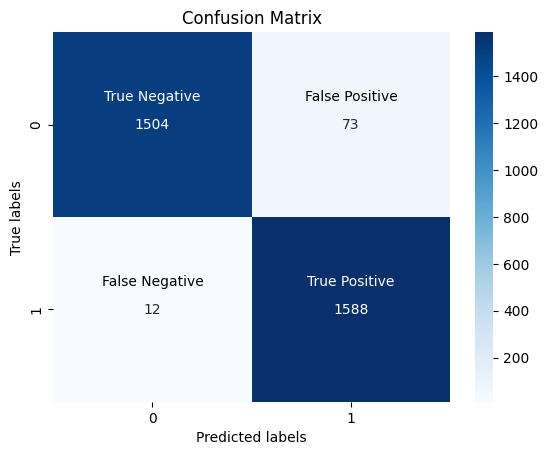

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)


clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

X_test_tfidf = vectorizer.transform(X_test)

train_pred = clf.predict(X_train_tfidf)
test_pred = clf.predict(X_test_tfidf)


print(classification_report(y_train,train_pred))

def plot_confusion_matrix(labels,pred):
  cm = confusion_matrix(labels,pred)

  sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', )

  # Set axis labels
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')

  def annotate():
    annotations = ["True Negative","False Positive","False Negative","True Positive"] 
    annot_idx = 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.35, annotations[annot_idx],
                    ha="center", va="center",
                    color="white" if (i+j)%2==0 else "black")
            annot_idx+=1
  annotate()
  plt.show()

plot_confusion_matrix(y_train,train_pred)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       395
           1       0.94      0.99      0.96       400

    accuracy                           0.96       795
   macro avg       0.96      0.96      0.96       795
weighted avg       0.96      0.96      0.96       795



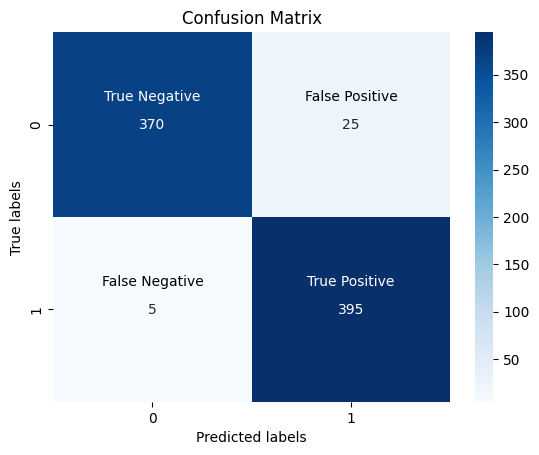

In [ ]:
print(classification_report(y_test,test_pred))
plot_confusion_matrix(y_test,test_pred)

# Test on Huggingface

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
!pip install zstandard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("oscar-corpus/OSCAR-2301", "th", streaming = True)

dataset_shuffle = dataset.shuffle()

In [ ]:
oscar = dataset_shuffle['train'].take(1000)


In [ ]:
oscar_list = [data for data in oscar]

oscar_df = pd.DataFrame(oscar_list)

In [ ]:
oscar_df=pd.read_csv("/content/drive/MyDrive/Openthaigpt/tmp_dataset.csv")

In [ ]:
oscar_df

In [ ]:
oscar_df["tokenized_text"] = oscar_df["text"].progress_apply(lambda x : " ".join(word_tokenize(x)))
oscar_tfidf = vectorizer.transform(oscar_df["tokenized_text"])
oscar_pred = clf.predict(oscar_tfidf)

oscar_df["pred"]=oscar_pred



100%|██████████| 3972/3972 [01:03<00:00, 62.60it/s] 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(oscar_df, oscar_df["labels"], test_size=0.2, random_state=42,stratify=oscar_df["labels"])

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth = 5)

model.fit(X_train[["log_score"]],y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
import re
from pythainlp.util import countthai

def check_containing_bad_keywords(text):

  porn_keywords =["คลิปหลุด","กระเจี๊ยว","คลิปโป๊","หนังโป๊","หนังโป้","หนังโป็","เรื่องเสียว","ซอยหี","ชักว่าว","ท่าหมา","ขย่มควย","เล่นเสียว","ควยใหญ่","หนังเอ็กซ์","แหกหี"]
  gamble_keywords = ["ufabet","UFABET","ล้มโต๊ะ", "เซียนสเต็ป","บอลเต็ง","แทงบอล","คาสิโน","บาคาร่า","เว็บสล็อต","เกมสล็อต","สล็อตออนไลน์","คาสิโนออนไลน์",
                    "หวยมาเลย์", "หวยฮานอย", "น้ำเต้าปูปลา", "หวยออนไลน์" , "แทงหวย" , "หวยหุ้น", "ยิงปลาออนไลน์" ,"ได้เงินจริง","บา คา ร่า"]
  movie_keywords =["ดูหนังออนไลน์","หนังออนไลน์","เว็บดูหนัง","หนังชนโรง","หนังใหม่ชนโรง","เสียงไทย","เสียงญี่ปุ่น","เสียงอังกฤษ"]
  like_keywords = ["ปั้มไลค์","รับจ้างกดไลค์","จ้างไลค์","ปั๊มไลค์","ปั่นไลค์","เพิ่มไลค์","ซื้อไลค์"]
  code_keywords =["padding:","display:","S3=n8","phpBB Debug","getElementById","innerHTML","parseInt","addEventListener","console\.log","checkCookieForTarget","setAttribute","getItem","if \(","else {","JSON\.stringify","onclick"]

  ratchakarn_website_keywords = ["คุณกำลังใช้งานแบบปิดการใช้ Javascript","Longdo Dictionary","นโยบายการคุ้มครองข้อมูลส่วนบุคคล","เงื่อนไขการให้บริการเว็บไซต์","นโยบายความปลอดภัย","นโยบายเว็บไซต์และการปฏิเสธความรับผิด","คุณอาจจะยังไม่ได้เข้าสู่ระบบหรือยังไม่ได้ลงทะเบียน","คุณไม่ได้เข้าสู่ระบบหรือคุณไม่มีสิทธิ์เข้าหน้านี้"]

  porn_keywords += [" ".join(list(kw)) for kw in porn_keywords]
  gamble_keywords += [" ".join(list(kw)) for kw in gamble_keywords]
  movie_keywords += [" ".join(list(kw)) for kw in movie_keywords]

  bad_keywords = porn_keywords + gamble_keywords + movie_keywords + like_keywords + code_keywords + ratchakarn_website_keywords

  sparse_bad_keywords = []

  pattern = '|'.join(bad_keywords)  
  return bool(re.search(pattern, text))

def check_ratio_bad_substring(text,n):
  month_to_count = ["มกราคม","กุมภาพันธ์","มีนาคม","เมษายน","พฤษภาคม","มิถุนายน","กรกฎาคม","สิงหาคม","กันยายน","ตุลาคม","พฤศจิกายน","ธันวาคม",
            "ม\.ค\.","ก\.พ\.","มี\.ค\.","เม\.ย\.","พ\.ค\.","มิ\.ย\.","ก\.ค\.","ส\.ค\.","ก\.ย\.","ต\.ค\.","พ\.ย\.","ธ\.ค\."]
  special_to_count = ["\{","\+","\}","/",":"]

  if len(re.findall("|".join(month_to_count),text))/n > 0.015:
    return ""

  if len(re.findall("|".join(special_to_count),text))/n > 0.075:
    return ""

  if len(re.findall(" ",text))/n > 0.13:
    return ""

  if len(re.findall(",",text))/n > 0.05:
    return ""

def remove_bad_substring(text):
  to_replace_keywords = ["Posted on","Posted by","Posted by:","Posted By:","สมาชิกหมายเลข [0-9,]+","อ่าน [0-9,]+ ครั้ง","เปิดดู [0-9,]+ ครั้ง","ดู [0-9,]+ ครั้ง","คะแนนสะสม: [0-9,]+ แต้ม","ความคิดเห็น: [0-9,]+",
                    "[0-9,]+ บุคคลทั่วไป กำลังดูบอร์ดนี้","หน้าที่แล้ว ต่อไป","ความคิดเห็นที่ [0-9,]+","[0-9,]+ สมาชิก และ [0-9,]+ บุคคลทั่วไป","กำลังดูหัวข้อนี้","เข้าสู่ระบบด้วยชื่อผู้ใช้",
                    "แสดงกระทู้จาก:","กระทู้: [0-9,]+","เว็บไซต์เรามีการใช้คุกกี้และเก็บข้อมูลผู้ใช้งาน โปรดศึกษาและยอมรับ นโยบายคุ้มครองข้อมูลส่วนบุคคล ก่อนใช้งาน",
                    "Privacy & Cookies: This site uses cookies. By continuing to use this website, you agree to their use\.",
                    "Previous\t\nNext\nLeave a Reply Cancel reply\nYou must be logged in to post a comment.\nSearch for:\nFeatured Post\n",
                    "Click to read more\nYou must be logged in to view or write comments\.","[0-9,]+ Views","Skip to content","Last Modified Posts","Last Updated:",
                    "\(อ่าน [0-9,]+ ครั้ง\)","Recent Comments","«.*?»","< --แสดงทั้งหมด-- >","นโยบายความเป็นส่วนตัว","เงื่อนไขการใช้เว็บไซต์","ตั้งค่าคุกกี้","ท่านยอมรับให้เว็บไซต์นี้จัดเก็บคุกกี้เพื่อประสบการณ์การใช้งานเว็บไซต์ที่ดียิ่งขึ้น",
                    "รวมถึงช่วยให้ท่านมีโอกาสได้รับข้อเสนอหรือเนื้อหาที่ตรงตามความสนใจของท่าน","ท่านสามารถดู Privacy Notice ของเว็บไซต์เรา ได้ที่นี่","You may be trying to access this site from a secured browser on the server. Please enable scripts and reload this page.",
                    "เผยแพร่: \d\d [ก-๙]+ \d\d\d\d \d\d:\d\d น\.","Last updated: \d\d [ก-๙]+\.[ก-๙]+\. \d\d\d\d \d\d:\d\d น\.","Lorem ipsum dolor sit amet, consectetur adipiscing elit\.",
                    "Search for:","Save my name, email, and website in this browser for the next time I comment","Your email address will not be published. Required fields are marked",
                    "Leave a Reply Cancel reply","((?:หน้าหลัก|เข้าสู่ระบบ|หน้าแรก) \|(?: .+(?:(?: \|)|$))+)","กลับหน้าแรก","ติดต่อเรา","Contact Us","#\w+","ติดต่อผู้ดูแลเว็บไซต์",
                    "หากท่านพบว่ามีข้อมูลใดๆที่ละเมิดทรัพย์สินทางปัญญาปรากฏอยู่ในเว็บไซต์โปรดแจ้งให้ทราบ","No related posts","Posted in","((?:Tags:|Tagged|Tag) (?:.{1,40}(?:,|\n|$))+)","ตอบ:","Sort by:",
                     "All rights reserved","ความยาวอย่างน้อย","ระบบได้ดำเนินการส่ง OTP","เป็นสมาชิกอยู่แล้ว\?","We use cookies","Cookie Settings",
                     "Homeหน้าหลัก", "Home หน้าหลัก", "ข่าวสารล่าสุด", "ปัญหา การใช้งาน", "ปัญหาการใช้งาน" "ผู้เขียน" ,"หัวข้อ:" ,"\*\* พร้อมส่ง \*\*"]
  
  return re.sub("|".join(to_replace_keywords),"",text)

def clean_text(text):

  n=len(text)
  
  if check_containing_bad_keywords(text) or check_ratio_bad_substring(text,n) or countthai(text)<50:
    return ""
  
  text= remove_bad_substring(text)

  return text



In [ ]:
oscar_df["clean_text1"] = oscar_df["text"].apply(clean_text)

In [ ]:
#classifier
oscar_df["clean_text2"] = oscar_df["pred"]==1

In [ ]:
#perplexity + classifier
oscar_df["clean_text3"] = model.predict(oscar_df[["log_score"]])

In [ ]:
# regex + classifier + perplexity
len(oscar_df[(oscar_df["clean_text2"]==False) | (oscar_df["clean_text1"]=="") | (oscar_df["clean_text3"]==1)])

2940

In [ ]:
2942/3972

0.7406847935548841

In [ ]:
for i,text in enumerate(oscar_df[(oscar_df["clean_text3"]==1) & (oscar_df["clean_text1"]!="")].sample(10)["text"].tolist()):
  print("text {}".format(i))
  print(text)
  print()

text 0
ที่โรงหนังเฮาส์ RCA เขาจะรวบรวมหนังเก่าคุณภาพของผู้กำกับชั้นครูมาให้ได้ชมกันทุกช่วงสิ้นเดือน เพื่อนำรายได้ไปสร้างห้องเก็บฟิล์มที่หอภาพยนตร์แห่งชาติ ส่วน ท่านมุ้ย ชวน “สตีเว่น สปีลเบิร์ก” ร่วมงานในหนังฟอร์มยักษ์ เพชรพระอุมา
เสี่ยเจียง-สมศักดิ์ เตชะรัตนประเสริฐ บอสใหญ่สหมงคลฟิล์ม ปลุกชีวิตหนังไทยในตำนานเมื่อกว่า 40 ปีก่อน โดยขอปัดฝุ่นหนังคุณภาพของผู้กำกับระดับบรมครู อาทิ หม่อมเจ้าชาตรีเฉลิม ยุคล , หม่อมหลวงพันธุ์เทวนพ เทวกุล, เพิ่มพล เชยอรุณ, ดอกดิน กัญญามาลย์ เรียงคิวเข้าฉายในสัปดาห์สุดท้ายของเดือน ตั้งแต่เดือนนี้ถึงเดือนสิงหาคม ที่โรงหนังเฮาส์ อาร์ซีเอ แค่ฟังชื่อหนังไม่ว่าจะเป็น แหม่มจ๋า , นกน้อย , เมืองในหมอก , มือปืน , สาละวิน , รอยไถ และช่างมันฉันไม่แคร์ ก็พอจะเป็นน้ำจิ้มเชิญชวนให้คอหนังมานั่งซึมซับอดีตผ่านแผ่นฟิล์มได้ไม่ยากเลย
งานนี้ท่านมุ้ยยังเผยเรื่องความคืบหน้าของหนัง ตำนานสมเด็จพระนเรศวร ว่าอาจจะขยายเรื่องราวยาวถึงขั้นต่อภาค 4 แต่ที่แน่นๆ ตอนนี้หนังภาค 3 ถ่ายทำใกล้เสร็จสมบูรณ์แล้ว เหลือเพียงขั้นตอนของคอมพิวเตอร์กราฟิกที่จะช่วยเติมเต็มความสมบูรณ์แบบของฉากยุทธหัตถี
ถึงแม้ว

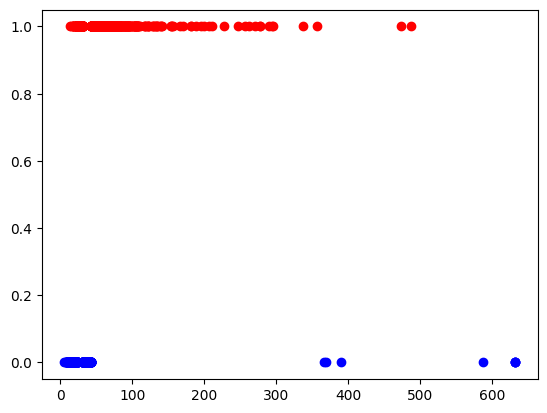

In [ ]:
import matplotlib.pyplot as plt 

sample_df1 = oscar_df[oscar_df["clean_text3"]==1]
sample_df2 = oscar_df[oscar_df["clean_text3"]==0]


plt.scatter(sample_df1["log_score"].tolist(),sample_df1["clean_text3"].tolist(),color="red")
plt.scatter(sample_df2["log_score"].tolist(),sample_df2["clean_text3"].tolist(),color="blue")
plt.show()

In [ ]:
oscar_df["clean_text3"].value_counts()

1    2145
0    1827
Name: clean_text3, dtype: int64

# Sample spam 

In [ ]:
spam_df = oscar_df[(oscar_df["clean_text3"]==1) & (oscar_df["clean_text1"]!="")]

In [ ]:
import numpy as np
x_data = spam_df["log_score"]

mu = np.mean(x_data)  # mean of x_data
sigma = np.std(x_data)  # standard deviation of x_data
x_curve = np.linspace(min(x_data), max(x_data), 100)  # x values for the curve
y_curve = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x_curve - mu)**2 / (2 * sigma**2))  # Gaussian curve equation

# plt.hist(x_data)

plt.plot(x_curve, y_curve, color='red', label='Gaussian Curve')

In [ ]:
def sample_text(texts,log_scores,percentage = 0.1 , replace = True):

  ''' sample from log score distribution of language model'''
  np.random.seed(0)

  lower_bound, upper_bound= min(log_scores), max(log_scores)

  mean, std = np.mean(log_scores), np.std(log_scores)

  sampled_scores = scipy.stats.truncnorm.rvs((lower_bound-mean)/std,
                                                    (upper_bound -
                                                    mean)/std,
                                                    loc=mean, scale=std, size=int(percentage*len(texts)))
  
  sampled_texts = []
  selected_score = []

  selected_idx = set()

  for samp_score in sampled_scores:

    min_diff, min_idx = float("inf"), -1

    min_score = -1

    for idx,s  in enumerate(log_scores) : 

      if idx in selected_idx :
        continue 

      diff = (samp_score-s)**2
      if  diff < min_diff:
        min_diff = diff
        min_idx = idx
        min_score = s

        
    sampled_texts.append(texts[min_idx])
    selected_score.append(min_score)

    if not replace : 
      selected_idx.add(min_idx)

  return sampled_texts , selected_score

  
texts = spam_df["text"].tolist()
log_scores = spam_df["log_score"].tolist()
percentage = 0.1


tmp, tmp_score = sample_text(texts, log_scores, percentage=percentage)
tmp2, tmp_score2 = sample_text(texts, log_scores,replace=False, percentage=percentage)

In [ ]:
for i in range(20):
  print(tmp[i])
  print()

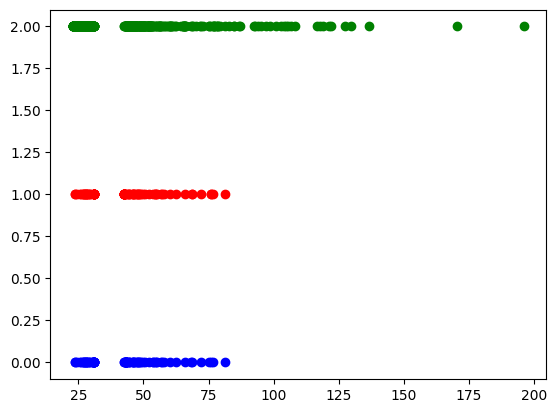

In [ ]:
import matplotlib.pyplot as plt 

plt.scatter(spam_df["log_score"].tolist(), [2]*len(spam_df),color="green")
plt.scatter(tmp_score, [1]*len(tmp_score),color="red")
plt.scatter(tmp_score2, [0]*len(tmp_score),color="blue")
plt.show()

In [ ]:
len(tmp),len(set(tmp)),len(tmp2),len(set(tmp2))

(214, 154, 214, 214)

In [ ]:
tmp 